In [18]:
import numpy as np
import os
import cv2
import random
import argparse
import cvxpy as cvx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline

 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

from sklearn.decomposition import PCA
from skimage.color import rgb2gray
#from src_algorithm import src_algorithm
from DMD_video_sampling import parse_videos
from face_detection import process_DMD_snapshots
font_small = {'fontsize': 8}
font_large = {'fontsize': 10}

shape = (5, 5)
IGNORE_FILES = ['.DS_Store']

In [26]:
def normalize_data_column(img_matrix):
    normalized_img = img_matrix / np.sqrt(np.sum(img_matrix ** 2))
    return normalized_img

def pca_dim_reduction(train_imgs, test_imgs, n_features):
    img_matrix_train = train_imgs.transpose()
    img_matrix_test = test_imgs.transpose()
    pca = PCA(n_components=n_features, svd_solver='randomized', whiten=True).fit(img_matrix_train)
    pca.fit(img_matrix_train)
    resized_matrix_train = pca.transform(img_matrix_train)
    resized_matrix_test = pca.transform(img_matrix_test)
    resized_matrix_train = resized_matrix_train.transpose()
    resized_matrix_test = resized_matrix_test.transpose()

    return resized_matrix_train, resized_matrix_test

def prep_train_test(train_path, test_path, options: dict):
    init_data_matrix = True
    TrainSet = {}
    class_label_train = []
    TestSet = {}
    class_label_test = []
    test_file = []

    dims = options['dims'] #either a tuple for downsampling or an integer for pca

    for folder in os.listdir(train_path):
        init_class_matrix = True
        if folder in IGNORE_FILES:
            continue
        class_folder = train_path + folder + os.sep
        class_vector = os.listdir(class_folder)

        for img_file in class_vector:
            if img_file in IGNORE_FILES:
                continue
            class_label_train.append(folder)
            img_path = train_path + folder + os.sep + img_file # absolute path to image
            X_orig = cv2.imread(img_path)

            try: # convert to greyscale if image is rgb
                X_orig.shape[2]
                X_orig = rgb2gray(X_orig)
            except IndexError:
                pass

            if options['feature_selection'] == 'downsampling':
                X = cv2.resize(X_orig, dims, interpolation = cv2.INTER_AREA)
            else:
                X = X_orig

            X = X.reshape(-1, 1)
            X = normalize_data_column(X)

            if init_class_matrix:
                D_c = X # initialize data matrix
                init_class_matrix = False
            else:
                D_c = np.hstack((D_c, X))

        if init_data_matrix: # this will run the first time
            D_train = D_c
            init_data_matrix = False
        else:
            D_train = np.hstack((D_train, D_c))

    # Now process test data
    init_data_matrix = True

    for folder in os.listdir(test_path):
        init_class_matrix = True
        if folder in IGNORE_FILES:
            continue
        class_folder = test_path + folder + os.sep
        class_vector = os.listdir(class_folder)

        for img_file in class_vector:
            if img_file in IGNORE_FILES:
                continue
            class_label_test.append(folder)
            img_path = test_path + folder + os.sep + img_file  # absolute path to image
            test_file.append(img_path)
            X_orig = cv2.imread(img_path)

            try:  # convert to greyscale if image is rgb
                X_orig.shape[2]
                X_orig = rgb2gray(X_orig)
            except IndexError:
                pass

            if options['feature_selection'] == 'downsampling':
                X = cv2.resize(X_orig, dims, interpolation = cv2.INTER_AREA)
            else:
                X = X_orig

            X = X.reshape(-1, 1)
            X = normalize_data_column(X)

            if init_class_matrix:
                D_c = X  # initialize data matrix
                init_class_matrix = False
            else:
                D_c = np.hstack((D_c, X))

        if init_data_matrix:  # this will run the first time
            D_test = D_c
            init_data_matrix = False
        else:
            D_test = np.hstack((D_test, D_c))

    if options['feature_selection'] == 'pca':
        D_train, D_test = pca_dim_reduction(D_train, D_test, dims)

    TrainSet['X'] = D_train
    TrainSet['y'] = np.array(class_label_train)
    TestSet['X'] = D_test
    TestSet['y'] = np.array(class_label_test)
    TestSet['files'] = test_file

    return TrainSet, TestSet

def src_algorithm(TrainSet, TestSet, num_classes, num_test_samples, sigma, thresh_certainty):
    classes = np.unique(TrainSet['y']) # which classes have been acquainted
    identity = []
    failed_imgs = []
    results = [] # a list of dictionaries with residuals and threshold certainty for each test sample
    num_recognized = 0
    false_pos = 0
    coeff_vectors = []

    for i in range(num_test_samples):

        y = TestSet['X'][:,i]
        D = TrainSet['X'] # Data matrix
        m, n = D.shape
        
        subject = {}
        subject['subject'] = TestSet['y'][i] # the true identity of the subject

        # do L1 optimization
        x = cvx.Variable(n)
        objective = cvx.Minimize(cvx.norm(x, 1))
        #constraints = [D@x == y]
        z = D @ x - y
        constraints = [cvx.norm(z, 2) <= sigma]
        prob = cvx.Problem(objective, constraints)
        result = prob.solve() # runs economy optimizer by default
        xp = np.array(x.value).squeeze()
        coeff_vectors.append(xp)

        residuals = np.zeros((num_classes))

        # calculate residuals for each class
        for j in range(num_classes):
            idx = np.where(classes[j] == TrainSet['y'])
            last_index = np.size(idx) - 1
            residuals[j] = np.linalg.norm(y - TrainSet['X'][:,idx[0][0]:idx[0][last_index]+1].dot(xp[idx]))

        min_res = np.min(residuals)

        mean_res = np.mean(residuals)
        certainty = 1-min_res/mean_res

        label_index = np.argmin(residuals)

        #if classes[label_index] != TestSet['y'][i] or thresh_certainty > certainty:
        if thresh_certainty > certainty:
            failed_imgs.append(TestSet['files'][i])
            identity.append(None)
            print(f"INTRUDER WARNING - Failed to recognize face in file {TestSet['files'][i]}!")
            subject['predicted'] = None
        else:
            print("RECOGNIZED AS: ", classes[label_index], "TRUE: ", TestSet['y'][i])
            subject['predicted'] = classes[label_index]
            identity.append(classes[label_index])
            num_recognized += 1
            
        
        subject['residuals'] = residuals
        subject['certainty'] = certainty
        
        results.append(subject)

    ### Calculate accuracy ###
    correct_num = [i for i in range(len(identity)) if identity[i] == TestSet['y'][i]]
    accuracy = len(correct_num)/num_test_samples * 100
    print(f"Predicted correctly: {len(correct_num)} out of {np.size(TestSet['y'])} test samples")

    return false_pos, num_recognized, accuracy, failed_imgs, results, coeff_vectors, classes

In [90]:
### Train and test path ###
data_folder = 'Data'
dest = os.path.join(os.getcwd(), data_folder)

train_path = os.path.join(dest, 'train') + os.sep
test_path = os.path.join(dest, 'test') + os.sep

test_new = os.path.join(os.getcwd(), 'Data/NewVideos') + os.sep


### Feature selection option ###
options = {'feature_selection': 'downsampling', 'dims': shape} # feature selection can be wither pca (eigenfaces) or downsampling
#options = {'feature_selection': 'pca', 'dims': 18}

TrainSet, TestSet = prep_train_test(train_path, test_new, options)
print(TrainSet['X'].shape, TestSet['X'].shape)

(25, 45) (25, 8)


## SRC FALSE POSITIVES

In [4]:
### SRC PLOTTTING FALSE POSITIVES ###
num_classes = len(set(TrainSet['y']))
num_test_samples = len(list(TestSet['y']))
sigma = 0.0001
thresh_certainty = 0
#thresh_certainty = 0.3 # Threshold for how "certain" the src algorithm should be when predicting the class.
                       # Certainty in the prediction that falls below this threshold is discarded
                       # Increasing this value will lead to stricter predictions. Put zero for no threshold
        
rec_rate = []
thresholds = []
fals = []

while thresh_certainty < 1:
    #print(f"Running SRC classifier with certainty threshold: {thresh_certainty}, and feature selection: {options['feature_selection']}")

    false_pos, num_rec, accuracy, failed, results, _, classes = src_algorithm(TrainSet, TestSet, num_classes, num_test_samples, sigma, thresh_certainty)
    rec_rate.append(num_rec)
    fals.append(false_pos)
    thresholds.append(thresh_certainty)
    thresh_certainty += 0.1
    
#print("Failed to classify images: \n")
#for f in failed:
#    print(f)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject5 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
Predicted correctly: 0 out of 11 test samples
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject5 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
Predicted correctly: 0 out of 11 test samples
RECOGN

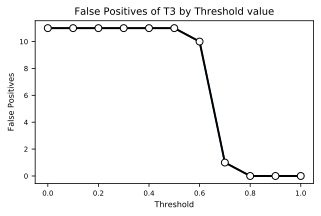

In [7]:
### Rec. Rate ###
fig = plt.figure(figsize=(5,3))
plt.plot(thresholds, rec_rate)
#plt.scatter(thresholds, fals, c='g')
plt.plot(thresholds, rec_rate, '-ok', color='black',
         markersize=7, linewidth=2,
         markerfacecolor='white')
plt.xlabel('Threshold', fontdict=font_small)
plt.ylabel('False Positives', fontdict=font_small)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
#plt.grid()
plt.title('False Positives of T3 by Threshold value', fontdict=font_large)
plt.show()
fig.savefig(f'Figures/false_positives.svg')

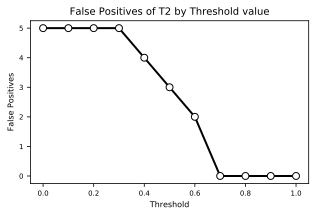

In [47]:
### False Positives ###
fig = plt.figure(figsize=(5,3))
#plt.scatter(thresholds, fals, c='g')
plt.plot(thresholds, fals, '-ok', color='black',
         markersize=7, linewidth=2,
         markerfacecolor='white')
plt.xlabel('Threshold', fontdict=font_small)
plt.ylabel('False Positives', fontdict=font_small)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
#plt.grid()
plt.title('False Positives of T2 by Threshold value', fontdict=font_large)
plt.show()
fig.savefig(f'Figures/false_positives.svg')

## REGULAR SRC

In [91]:
### SRC PLOTTTING RESIDUALS ###
num_classes = len(set(TrainSet['y']))
num_test_samples = len(list(TestSet['y']))
sigma = 0.00001
thresh_certainty = 0.3 # Threshold for how "certain" the src algorithm should be when predicting the class.
                       # Certainty in the prediction that falls below this threshold is discarded
                       # Increasing this value will lead to stricter predictions. Put zero for no threshold

print(f"Running SRC classifier with certainty threshold: {thresh_certainty}, and feature selection: {options['feature_selection']}")

_, _, accuracy, failed, results, coeff_vectors, classes = src_algorithm(TrainSet, TestSet, num_classes, num_test_samples, sigma, thresh_certainty)


Running SRC classifier with certainty threshold: 0.3, and feature selection: downsampling
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
RECOGNIZED AS:  subject2 TRUE:  subject?
RECOGNIZED AS:  subject3 TRUE:  subject?
RECOGNIZED AS:  subject4 TRUE:  subject?
Predicted correctly: 0 out of 8 test samples


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [55]:
print(results[0]['subject'])

subject2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


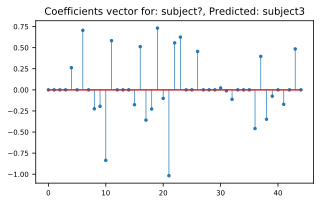

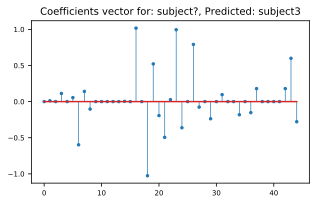

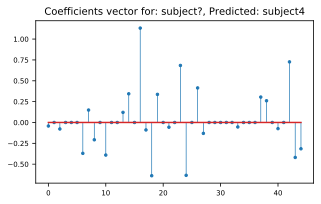

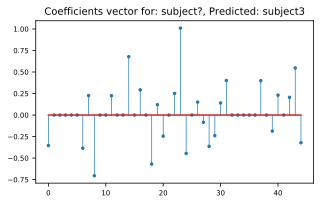

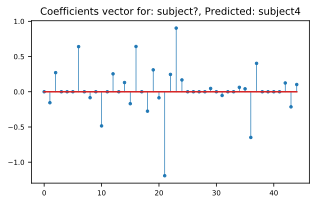

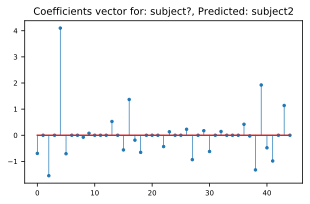

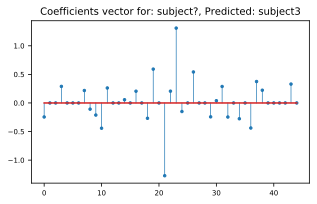

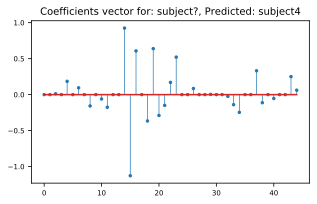

In [92]:
### Plot Coefficient vectors ###

path = os.path.join(os.getcwd(), 'Figures')

x = np.arange(len(coeff_vectors[0]))
num_predicted = len(results)

#for coeffs in coeff_vectors:
for i in range(num_predicted):
    label = results[i]['subject']
    predicted = results[i]['predicted']
    
    plt.figure(figsize=(5,3))
    plt.title(f'Coefficients vector for: {label}, Predicted: {predicted}', fontdict=font_large)
    markerline, stemlines, baseline = plt.stem(x, coeff_vectors[i])
    plt.setp(stemlines, 'linewidth', 0.7)
    plt.setp(markerline, markersize = 2.5)
    plt.setp(markerline, 'linewidth', 1)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    i += 1
    #plt.savefig(f'Figures/T2_coeffs_ds.svg')


In [57]:
### Set color Palette ###

colors = ['#78C850',  # Grass
          #'#F08030',  # Fire
          '#6890F0',  # Water
          '#A8B820',  # Bug
          '#A8A878',  # Normal
          '#A040A0',  # Poison
          #'#F8D030',  # Electric
          #'#E0C068',  # Ground
          '#EE99AC',  # Fairy
          '#C03028',  # Fighting
          '#F85888',  # Psychic
          '#B8A038',  # Rock
          '#705898',  # Ghost
          '#98D8D8',  # Ice
          '#7038F8',  # Dragon
          ]

colors2 = ['#b4d0df',
           '#8bc4fc',
           '#97bbc6',
           '#d7f4fa',
           '#c4cebc',
           '#d0e1d3',
           '#705898',  # Ghost
           '#98D8D8',  # Ice
           ]

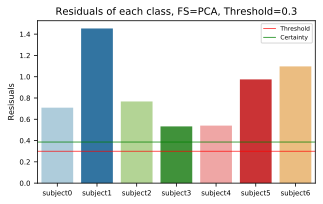

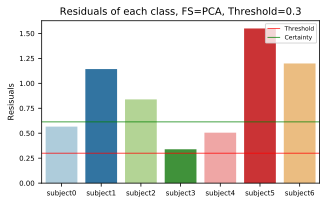

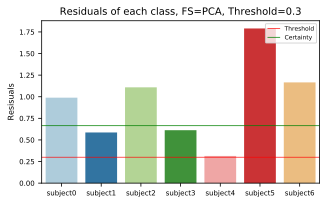

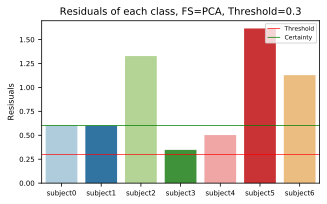

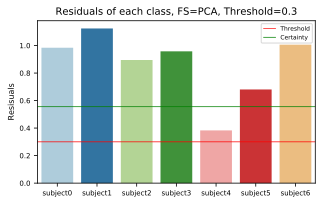

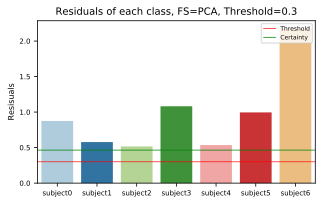

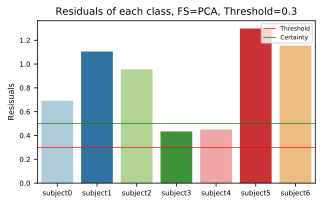

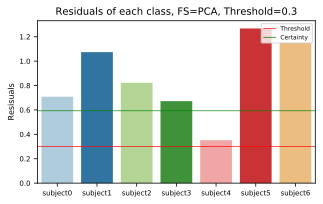

In [93]:
### Plot residuals PCA ###

path = os.path.join(os.getcwd(), 'Figures')

i = 0

labels = ['threshold', 'certainty']
#palette = sns.color_palette("Set2")
#palette = sns.color_palette('deep')
palette = sns.color_palette("Paired")
#palette = sns.color_palette("hls", 8)

for subject in results:
    residuals = subject['residuals']
    certainty = subject['certainty']
    
    plt.figure(figsize=(5,3))
    #sns.set_palette("pastel")
    graph = sns.barplot(x=classes, y=residuals, palette=palette)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.ylabel('Resisuals', fontdict = font_small)
    plt.title('Residuals of each class, FS=PCA, Threshold=0.3', fontdict=font_large)
    graph.axhline(thresh_certainty, color='r', label='Threshold', lw=0.7)
    graph.axhline(certainty, color='g', label='Certainty', lw=0.7)
    
    plt.legend(bbox_to_anchor=(1, 1), loc=1, prop={"size":6})
    #plt.savefig(f'Figures/T2{i}pca.svg')
    i += 1

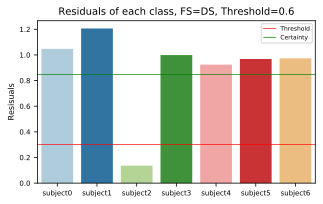

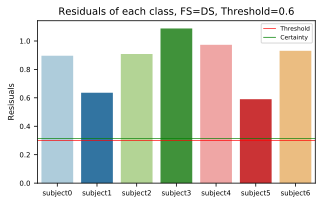

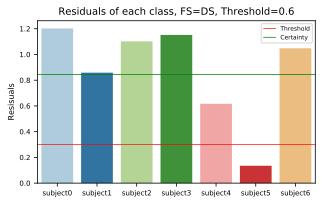

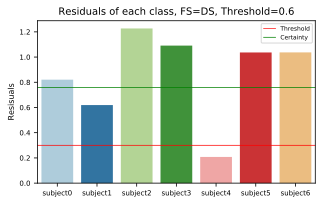

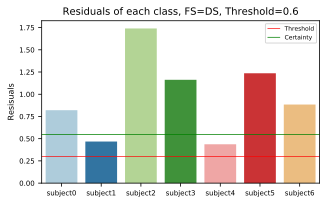

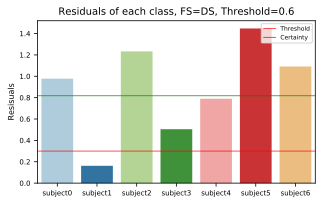

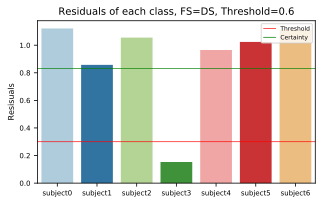

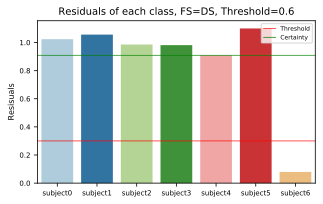

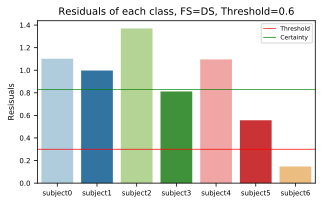

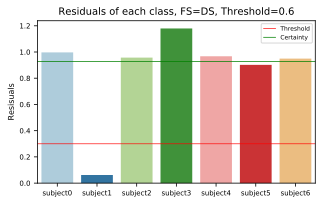

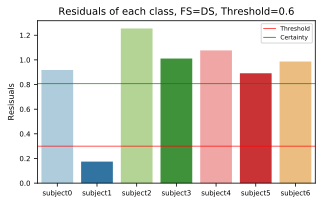

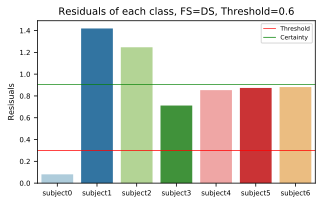

In [60]:
### Plot residuals DS ###

path = os.path.join(os.getcwd(), 'Figures')

i = 0

labels = ['threshold', 'certainty']
palette = sns.color_palette("Paired")

for subject in results:
    residuals = subject['residuals']
    certainty = subject['certainty']
    
    plt.figure(figsize=(5,3))
    #sns.set_palette("pastel")
    graph = sns.barplot(x=classes, y=residuals, palette=palette)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.ylabel('Resisuals', fontdict = font_small)
    plt.title('Residuals of each class, FS=DS, Threshold=0.6', fontdict=font_large)
    graph.axhline(thresh_certainty, color='r', label='Threshold', lw=0.7)
    graph.axhline(certainty, color='g', label='Certainty', lw=0.7)
    
    plt.legend(bbox_to_anchor=(1, 1), loc=1, prop={"size":6})
    plt.savefig(f'Figures/T3{i}ds.svg')
    i += 1